In [1]:
import sys
sys.path.append('../../src')

from common import common, transform, json
from tracker import main as tr
from individual_activity import main as ia
from group_activity import main as ga
from display.display import display
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Indivisual Activity をロード

In [2]:
room_num = '09'
date = '20210304'
name_train = 'pass1'
name_test = 'pass2'

In [3]:
individual_activity_json_train = os.path.join(
    common.data_dir, '{0}/{1}/{2}/json/individual_activity.json'.format(room_num, date, name_train))
individual_activity_json_test = os.path.join(
    common.data_dir, '{0}/{1}/{2}/json/individual_activity.json'.format(room_num, date, name_test))
field_path = os.path.join(
    common.data_dir, 'field.png')

In [4]:
# homography
field_raw = cv2.imread(field_path)
p_video = common.homo[room_num][0]
p_field = common.homo[room_num][1]
homo_train = transform.Homography(p_video, p_field, field_raw.shape)

field_raw = cv2.imread(field_path)
p_video = common.homo[room_num][0]
p_field = common.homo[room_num][1]
homo_test = transform.Homography(p_video, p_field, field_raw.shape)

In [5]:
individual_activity_data_train = json.load(individual_activity_json_train)
individual_activity_data_test = json.load(individual_activity_json_test)

In [8]:
from common.json import IA_FORMAT
from individual_activity.individual_activity import IndividualActivity

def make_individuals(datas, homo):
    individuals = {}
    for data in datas:
        label = data[IA_FORMAT[0]]
        frame_num = data[IA_FORMAT[1]]
        keypoints = np.array(data[IA_FORMAT[2]])

        if label not in individuals:
            ia = IndividualActivity(label, frame_num, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.keypoints_lst.append(keypoints)
        for f in IA_FORMAT[3:]:
            ia.indicator_dict[f].append(data[f])
            
    return individuals

In [9]:
individuals_train = make_individuals(individual_activity_data_train, homo_train)
individuals_test = make_individuals(individual_activity_data_test, homo_test)

# 特徴量抽出とデータ生成

In [207]:
from common.functions import gauss, cos_similarity
from common.default import PASSING_DEFAULT

# def extract_features(label1, label2, frame_num, individuals):
#     individual1 = individuals[label1]
#     pos1 = individual1.get_data('position', frame_num)
#     body1 = individual1.get_data('body_vector', frame_num)
#     arm1 = individual1.get_data('arm', frame_num)
#     if pos1 is None or body1 is None or arm1 is None:
#         return None
    
#     individual2 = individuals[label2]
#     pos2 = individual2.get_data('position', frame_num)
#     body2 = individual2.get_data('body_vector', frame_num)
#     arm2 = individual2.get_data('arm', frame_num)
#     if pos2 is None or body2 is None or arm2 is None:
#         return None
    
#     norm = np.linalg.norm(np.array(pos1) - np.array(pos2), ord=2)
#     opposite = np.abs(cos_similarity(body1, body2))
#     distance_prob = gauss(
#         norm,
#         mu=PASSING_DEFAULT['gauss_mu'],
#         sigma=PASSING_DEFAULT['gauss_sig'])

#     return [distance_prob, opposite, arm1, arm2]

def extract_features(label1, label2, frame_num, individuals):
    individual1 = individuals[label1]
    pos1 = individual1.get_data('position', frame_num)
    body1 = individual1.get_data('body_vector', frame_num)
    arm1 = individual1.get_data('arm', frame_num)
    if pos1 is None or body1 is None or arm1 is None:
        return None
    
    individual2 = individuals[label2]
    pos2 = individual2.get_data('position', frame_num)
    body2 = individual2.get_data('body_vector', frame_num)
    arm2 = individual2.get_data('arm', frame_num)
    if pos2 is None or body2 is None or arm2 is None:
        return None
    
    norm = np.linalg.norm(np.array(pos1) - np.array(pos2), ord=2)
    cos_sim = cos_similarity(body1, body2)
    distance_prob = gauss(
        norm,
        mu=PASSING_DEFAULT['gauss_mu'],
        sigma=PASSING_DEFAULT['gauss_sig'])
    arm = np.average([arm1, arm2])

    return [distance_prob, cos_sim, arm]
#     return [cos_sim, arm]

In [208]:
# train data
csv_path = os.path.join(common.data_dir, '{0}/{1}/{2}/csv/data.csv'.format(room_num, date, name_train))
csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

train_x_dict = {}
train_y_dict = {}
for row in csv_data:
    features = extract_features(row[1], row[2], row[0], individuals_train)
    key = str(row[1]) + str(row[2])
    
    if key not in train_x_dict:
        train_x_dict[key] = []
        train_y_dict[key] = []
        
    if features is not None:
        train_x_dict[key].append(features)
        train_y_dict[key].append(row[3])

In [209]:
train_x_dict['01'][0]

[0.37539866428398605, 0.4035919711717402, 0.26160166510262584]

In [210]:
# test data
csv_path = os.path.join(common.data_dir, '{0}/{1}/{2}/csv/data.csv'.format(room_num, date, name_test))
csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

test_x_dict = {}
test_y_dict = {}
for row in csv_data:
    features = extract_features(row[1], row[2], row[0], individuals_test)
    key = str(row[1]) + str(row[2])
    
    if key not in test_x_dict:
        test_x_dict[key] = []
        test_y_dict[key] = []
        
    if features is not None:
        test_x_dict[key].append(features)
        test_y_dict[key].append(row[3])

In [211]:
test_x_dict['01'][0]

[0.9404128569860587, -0.95681875383744, 0.16445653107812785]

# 分布をプロット

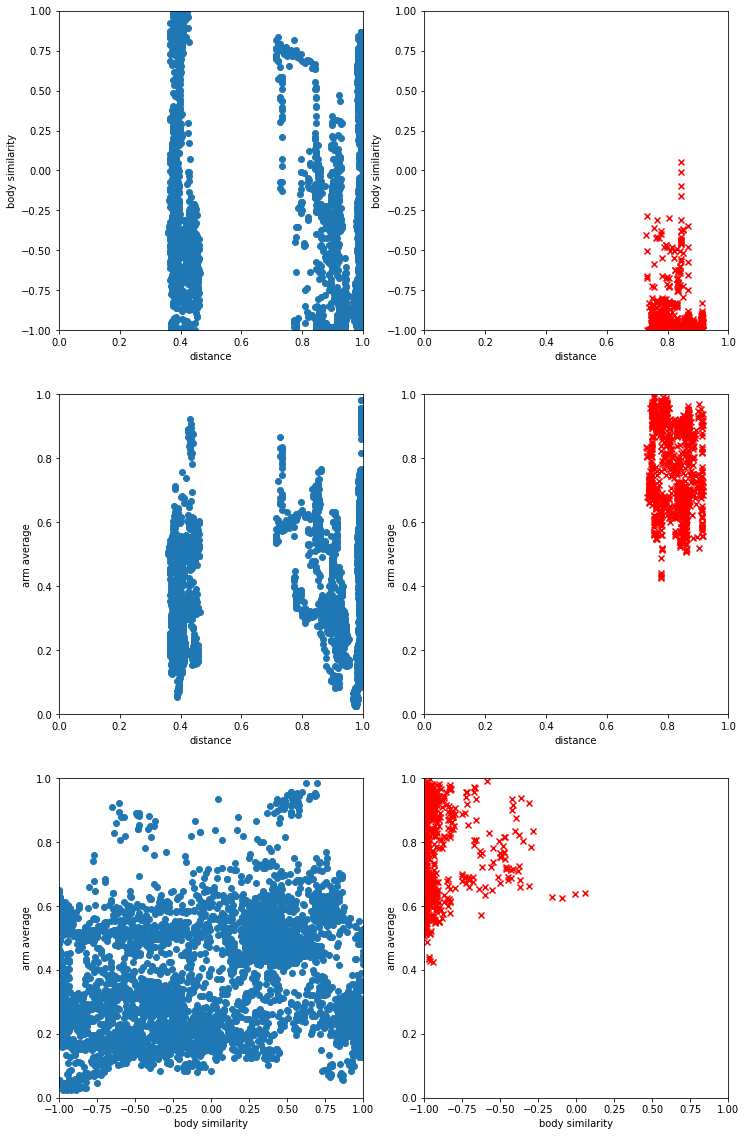

In [212]:
# columns = ['distance', 'body simirality', 'arm1', 'arm2']

# train_x = []
# train_y = []
# for x, y in zip(train_x_dict.values(), train_y_dict.values()):
#     train_x += x
#     train_y += y

# x_t_true = np.array(train_x)[np.where(np.array(train_y) == 1)].T
# x_t_false = np.array(train_x)[np.where(np.array(train_y) == 0)].T

# fig = plt.figure(figsize=(20, 12))

# ax1 = fig.add_subplot(231, xlim=(0, 1), ylim=(0, 1), xlabel=columns[0], ylabel=columns[1])
# ax1.scatter(x_t_false[0], x_t_false[1])
# ax1.scatter(x_t_true[0], x_t_true[1], color='red', marker='x')

# ax2 = fig.add_subplot(232, xlim=(0, 1), ylim=(0, 1), xlabel=columns[0], ylabel=columns[2])
# ax2.scatter(x_t_false[0], x_t_false[2])
# ax2.scatter(x_t_true[0], x_t_true[2], color='red', marker='x')

# ax3 = fig.add_subplot(233, xlim=(0, 1), ylim=(0, 1), xlabel=columns[0], ylabel=columns[3])
# ax3.scatter(x_t_false[0], x_t_false[3])
# ax3.scatter(x_t_true[0], x_t_true[3], color='red', marker='x')

# ax4 = fig.add_subplot(234, xlim=(0, 1), ylim=(0, 1), xlabel=columns[1], ylabel=columns[2])
# ax4.scatter(x_t_false[1], x_t_false[2])
# ax4.scatter(x_t_true[1], x_t_true[2], color='red', marker='x')

# ax5 = fig.add_subplot(235, xlim=(0, 1), ylim=(0, 1), xlabel=columns[1], ylabel=columns[3])
# ax5.scatter(x_t_false[1], x_t_false[3])
# ax5.scatter(x_t_true[1], x_t_true[3], color='red', marker='x')

# ax6 = fig.add_subplot(236, xlim=(0, 1), ylim=(0, 1), xlabel=columns[2], ylabel=columns[3])
# ax6.scatter(x_t_false[2], x_t_false[3])
# ax6.scatter(x_t_true[2], x_t_true[3], color='red', marker='x')

columns = ['distance', 'body similarity', 'arm average']

train_x = []
train_y = []
for x, y in zip(train_x_dict.values(), train_y_dict.values()):
    train_x += x
    train_y += y

x_t_true = np.array(train_x)[np.where(np.array(train_y) == 1)].T
x_t_false = np.array(train_x)[np.where(np.array(train_y) == 0)].T

fig = plt.figure(figsize=(12, 20))

ax1 = fig.add_subplot(321, xlim=(0, 1), ylim=(-1, 1), xlabel=columns[0], ylabel=columns[1])
ax1.scatter(x_t_false[0], x_t_false[1])
ax1 = fig.add_subplot(322, xlim=(0, 1), ylim=(-1, 1), xlabel=columns[0], ylabel=columns[1])
ax1.scatter(x_t_true[0], x_t_true[1], color='red', marker='x')

ax2 = fig.add_subplot(323, xlim=(0, 1), ylim=(0, 1), xlabel=columns[0], ylabel=columns[2])
ax2.scatter(x_t_false[0], x_t_false[2])
ax2 = fig.add_subplot(324, xlim=(0, 1), ylim=(0, 1), xlabel=columns[0], ylabel=columns[2])
ax2.scatter(x_t_true[0], x_t_true[2], color='red', marker='x')

ax3 = fig.add_subplot(325, xlim=(-1, 1), ylim=(0, 1), xlabel=columns[1], ylabel=columns[2])
ax3.scatter(x_t_false[1], x_t_false[2])
ax3 = fig.add_subplot(326, xlim=(-1, 1), ylim=(0, 1), xlabel=columns[1], ylabel=columns[2])
ax3.scatter(x_t_true[1], x_t_true[2], color='red', marker='x')

# 学習・検証

In [213]:
from sklearn.svm import SVC

In [214]:
svm = SVC()
train_x = []
train_y = []
for x, y in zip(train_x_dict.values(), train_y_dict.values()):
    train_x += x
    train_y += y
    
svm.fit(x, y)

SVC()

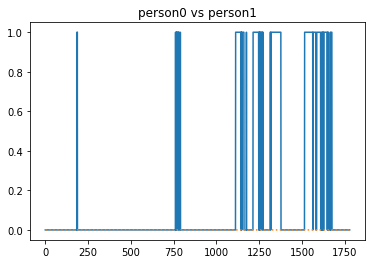

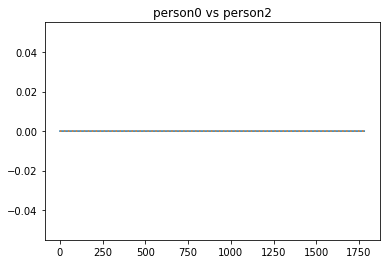

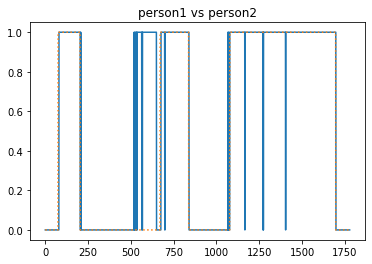

In [215]:
for persons, x, y in zip(train_x_dict.keys(), train_x_dict.values(), train_y_dict.values()):
    pred = svm.predict(x)
    plt.plot(pred)
    plt.plot(y, linestyle=':')
    plt.title('person{0} vs person{1}'.format(persons[0], persons[1]))
    plt.show()

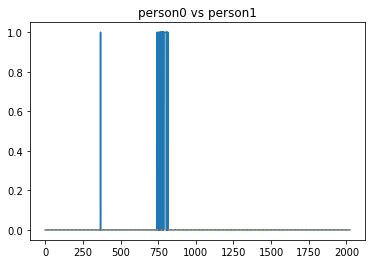

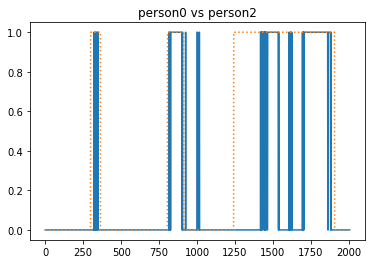

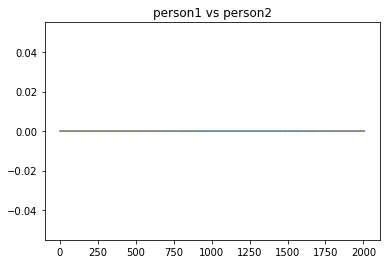

In [216]:
for persons, x, y in zip(test_x_dict.keys(), test_x_dict.values(), test_y_dict.values()):
    pred = svm.predict(x)
    plt.plot(pred)
    plt.plot(y, linestyle=':')
    plt.title('person{0} vs person{1}'.format(persons[0], persons[1]))
    plt.show()